In [1]:
# imports
import atracker as atr
import ast
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Pool
from pybt.trackers.boris import track_to_condition
import warnings
import time
from IPython.display import Markdown as md
from IPython.core.display import display, HTML, Markdown
warnings.filterwarnings('ignore')
%matplotlib notebook

# displaying matrices side by side
css = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(css))

### Settings

In [2]:
# settings
particle = 'proton'       # particle name: 'proton' or 'carbon12'
en_per_unit_MeV = 26e3    # kinetic energy of the beam
track_end_z_m = 2.5       # approximate location in longitudinal direction of the magnet at where to stop the tracking

# input angle and position of the beam in the global reference system
# values base on discussion with M. Fraser and https://codimd.web.cern.ch/05LpRgDIRIKUpRnTWTfbEA
ang_glob = (0.0682, 0.0)
pos_glob = (6.490e-02,  0.0, -2.51e+00)

read_fm = True            # read out the field map
interpolate_fm = True     # prepare the interpolated field map for tracking
fm_path = '/eos/project-b/beam-transfer-physics/public/data/ps-main-unit-type-u/maps/' # path to the field map file
fm_file = 'MUU_xy_grid.table'
save_ref_traj = False     # save the reference trajectory to a file

# labels for parameters of the 6x6 transport matrix
var_labels = {
    "x": " x [m]",
    "y": " y [m]",
    "xp": " xp [rad]",
    "yp": " yp [rad]",
    "t": " T [m]",
    "D": " D [1]",
} 

if read_fm:
    df = pd.read_csv(fm_path+fm_file,delim_whitespace=True, skiprows=8, names=['x', 'y', 'z', 'Bx', 'By', 'Bz'])
    
    # mirroring the field map (wrt y=0) as only half of the magnet field is in the file
    df_mir = df.copy() #copies a list instead of pointing to the same list
    df_mir[["y", "Bx", "Bz"]] = df_mir[["y", "Bx", "Bz"]].apply(np.negative) #multiply by minus 1 the y, Bx and Bz columns
    df_mir = df_mir.drop(df_mir[df_mir['y']==0.0].index) #.drop only select a smaller part of the data frame. Not sure what what the inner part selects

    fieldmap = pd.concat([df, df_mir]) # concatenate joins the two dataframes one after the other

    fieldmap.sort_values(by=['x','y'], inplace=True) #Sorts first the x column and then the y one. See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
    fieldmap['Bmod'] = np.sqrt(fieldmap['Bx']**2+fieldmap['By']**2+fieldmap['Bz']**2) #Modulus of the B field. Calulates the length of the vector field and adds it into a additional column
    for axis in ['x', 'y', 'z']: #Loops through these three columns 
        axis_val = fieldmap[axis].unique() #List containing the unique values of each column
        print('In the direction {:} we have {:} values from {:} to {:} in steps of {:}'.format(axis, len(axis_val), axis_val.min(), axis_val.max(), np.unique(np.diff(axis_val)).mean().round(6)))
        #.diff calculates the a[i+1] - a[i]. Basically outputs the steps
        # then you take the mean of the unique steps and round to 6 figures after the decimal
        
    print('And average fields are')    
    print(fieldmap[['Bx', 'By', 'Bz']].mean())    #The syntax is you take the mean of each element in the list

if interpolate_fm:
    interp_fieldmap = atr.interpolate_fieldmap(fieldmap)

In the direction x we have 201 values from -0.76 to 0.76 in steps of 0.0076
In the direction y we have 201 values from -0.9 to 0.9 in steps of 0.009
In the direction z we have 527 values from -2.63 to 2.63 in steps of 0.01
And average fields are
Bx    8.162681e-19
By   -3.424371e-04
Bz    4.846168e-21
dtype: float64


In [3]:
# functions

# magnetic field at position x at time based on the field map values
def func_B(x, time):
    """ return interpolated values of magnetic field components
    at point x and time """
    Bxi_p = interp_fieldmap['Bx'](x).squeeze()
    Byi_p = interp_fieldmap['By'](x).squeeze()
    Bzi_p = interp_fieldmap['Bz'](x).squeeze()
    return np.array([Bxi_p, Byi_p, Bzi_p])
    
def track_one_particle(input_zip, time_step=4e-12, particle=particle):
    """ run one particle to condition 
    the initial particle parameters and the end-tracking condition is specified in input_zip """
    
    # distribution and type information on the particle plus the tracking-end condition
    id_part, x0, p0, t0, track_is_inside = input_zip

    xs, ps, ts, _ = track_to_condition(track_is_inside,
                                       x = x0,
                                       p = p0,
                                       t = t0,
                                       mass = atr.Particle(particle).get_e0_eV(),
                                       n_charges = atr.Particle(particle).get_z(),
                                       time_step = time_step,
                                       return_full_track = True,
                                       func_B = func_B)
    
#     print("Len of xs = {}".format(len(xs)))
    return pd.DataFrame({'id': [id_part] * len(xs),
                         'k': list(range(0, len(xs))),
                         'x': np.array(xs)[:, 0],
                         'y': np.array(xs)[:, 1],
                         'z': np.array(xs)[:, 2],
                         'Px': np.array(ps)[:, 0],
                         'Py': np.array(ps)[:, 1],
                         'Pz': np.array(ps)[:, 2],
                         't': np.array(ts)})

def trackend_line(ref_particle, track_end_z_m):
    """ return the condition to finish the tracking of a whole set of particles
    based on the reference particle of distribution ref_particle
    and the approximate end condition track_end_z_m """
    
    # initial condition of end for the reference particle
    track_is_inside_ref = lambda x, p, t : x[2] < track_end_z_m
    input_zip = (ref_particle+(track_is_inside_ref,))
    
    # run reference particle
    tracks_ref = track_one_particle(input_zip)
    tracks_ref = atr.Tracks([tracks_ref], particle)
    
    return tracks_ref.get_track_condition() 

### Generate set of 13 particles

In [4]:
setGen = atr.SetGenerator(particle)

# distribution of the reference particle in local coordinate system 
distr_part_ref = {'dX': 0, 'dXP': 0, 'dY': 0, 'dYP': 0, 'dS': 0, 'en_MeV': en_per_unit_MeV, 'dt': 0}

# set of distributions for 13 particles in local coordinate system
set13_local = setGen.get_part13_local(distr_part_ref, dX=1e-3, dXP=1e-3, dY=1e-3, dYP=1e-3, dt=4e-12, dD=1e-3)

# set of distributions for 13 particles in global coordinate system to be used for tracking
set13_global = setGen.get_partset_global(set_local=set13_local, pos_glob0=pos_glob, ang_glob0=ang_glob)

### Run set of 13 particles

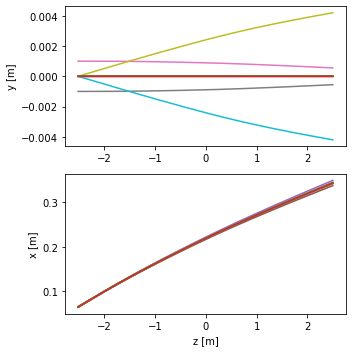

In [5]:
# run reference particle to determine the tracking-end line for the entire set
(endline_a, endline_b) = trackend_line(ref_particle=set13_global[0], track_end_z_m=track_end_z_m)
def track_is_inside(x ,p, t, a=endline_a, b=endline_b):
    return x[0] < endline_a * x[2] + endline_b   

# run the set of particles
input_zip = [set13_global[i]+(track_is_inside,) for i in range(len(set13_global))]
with Pool(6) as p:
    tracks_set = p.map(track_one_particle, input_zip)
        
tracks = atr.Tracks(tracks_set, particle)

# plot the trajectories
if True:
    ax = tracks.plot_track(pid=0)
    for pid in range(0, len(set13_global)):
        tracks.plot_track(pid=pid, legend = False, axes = ax)

# save the reference trajectory to a csv file
if save_ref_traj:
    tracks.save_ref_to_csv('PS_26GeV_ref_trajectory.csv')

### Transport matrix

In [6]:
# last step of the reference particle trajectory
k_last = tracks.get_ref_last_k()

# transport matrices of the system
mat_f = tracks.get_transport_matrix(k = k_last, ret = 'mat')
mat_f_madx = tracks.get_madx_matrix(mat_arr = mat_f, k = k_last)
display(atr.style_df_transport_matrix(mat_f),
        atr.style_df_transport_matrix(mat_f_madx,
                                      index_names = ["x [m]", "px [1]", "y [m]", "py [1]", "T [m]", "PT [1]"],
                                      columns_names = ["x0 [m]", "px0 [1]", "y0 [m]", "py0 [1]", "T0 [m]", "PT0 [1]"]))

,x0 [m],xp0 [rad],y0 [m],yp0 [rad],T0 [m],D0 [1]
x [m],1.5159,5.9145,0.0000,0.0000,-0.0000,0.0688
xp [rad],0.2033,1.4532,0.0000,0.0000,-0.0000,0.0248
y [m],-0.0000,-0.0000,0.5552,4.2020,-0.0000,0.0000
yp [rad],-0.0000,-0.0000,-0.1580,0.6054,-0.0000,0.0000
T [m],-0.0236,-0.0465,0.0000,0.0000,1.0000,0.0058
D [1],-0.0000,0.0000,0.0000,0.0000,-0.0000,1.0000


,x0 [m],px0 [1],y0 [m],py0 [1],T0 [m],PT0 [1]
x [m],1.5159,5.9145,0.0000,0.0000,-0.0000,0.0688
px [1],0.2033,1.4532,0.0000,0.0000,-0.0000,0.0248
y [m],-0.0000,-0.0000,0.5552,4.2020,-0.0000,0.0000
py [1],-0.0000,-0.0000,-0.1580,0.6054,-0.0000,0.0000
T [m],-0.0236,-0.0465,0.0000,0.0000,1.0000,0.0058
PT [1],-0.0000,0.0000,0.0000,0.0000,-0.0000,1.0000


# Extracting a Matrix from MAD-X

In [7]:
def get_matrix_from_twiss(twiss):
    elem = twiss.iloc[-1] # iloc[-1] takes last row of the data frame
    matExtracted = np.matrix([
        elem[['re11', 're12', 're13', 're14', 're15', 're16']].values.astype(float),
        elem[['re21', 're22', 're23', 're24', 're25', 're26']].values.astype(float),
        elem[['re31', 're32', 're33', 're34', 're35', 're36']].values.astype(float),
        elem[['re41', 're42', 're43', 're44', 're45', 're46']].values.astype(float),
        elem[['re51', 're52', 're53', 're54', 're55', 're56']].values.astype(float),
        elem[['re61', 're62', 're63', 're64', 're65', 're66']].values.astype(float),
    ])
    return matExtracted


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.07.12 15:22:42      +
  ++++++++++++++++++++++++++++++++++++++++++++
{'s1': <Sequence: s1>}


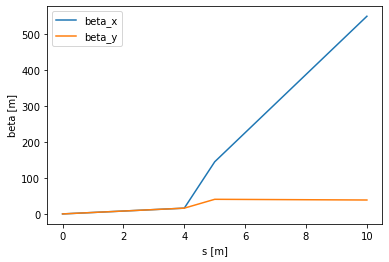

In [8]:
from cpymad.madx import Madx
madx = Madx(command_log="commandlog") #Writes the errors in this file once madx has quit
#madx.options(verbose=True, echo=True, debug=True)
madx.option(echo=False, warn=False, twiss_print=False) #Hides the output in the terminal

madx.beam(particle='proton', pc=25)

madx.command.sequence.clone('S1', l=10)
madx.command.endsequence()

madx.command.matrix.clone('CustomMatrix', L=1,
                                        rm11=mat_f_madx[0][0], rm12=mat_f_madx[0][1], rm13=mat_f_madx[0][2], rm14=mat_f_madx[0][3], rm15=mat_f_madx[0][4], rm16=mat_f_madx[0][5],
                                        rm21=mat_f_madx[1][0], rm22=mat_f_madx[1][1], rm23=mat_f_madx[1][2], rm24=mat_f_madx[1][3], rm25=mat_f_madx[1][4], rm26=mat_f_madx[1][5],
                                        rm31=mat_f_madx[2][0], rm32=mat_f_madx[2][1], rm33=mat_f_madx[2][2], rm34=mat_f_madx[2][3], rm35=mat_f_madx[2][4], rm36=mat_f_madx[2][5],
                                        rm41=mat_f_madx[3][0], rm42=mat_f_madx[3][1], rm43=mat_f_madx[3][2], rm44=mat_f_madx[3][3], rm45=mat_f_madx[3][4], rm46=mat_f_madx[3][5],
                                        rm51=mat_f_madx[4][0], rm52=mat_f_madx[4][1], rm53=mat_f_madx[4][2], rm54=mat_f_madx[4][3], rm55=mat_f_madx[4][4], rm56=mat_f_madx[4][5],
                                        rm61=mat_f_madx[5][0], rm62=mat_f_madx[5][1], rm63=mat_f_madx[5][2], rm64=mat_f_madx[5][3], rm65=mat_f_madx[5][4], rm66=mat_f_madx[5][5])

madx.command.seqedit(sequence='S1')
madx.command.install(element='M1', class_='CustomMatrix', at='4.5')
madx.command.endedit()

print(madx.sequence)

madx.use(sequence="S1")
twiss = madx.twiss(betx=1, bety=1, rmatrix=True).dframe()


%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(twiss.s, twiss.betx,label='beta_x')
plt.plot(twiss.s, twiss.bety,label='beta_y')
plt.xlabel('s [m]')
plt.ylabel('beta [m]')
plt.legend()
plt.show()

matExtracted = get_matrix_from_twiss(twiss)

In [9]:
print (matExtracted)

[[ 2.53236591e+00  2.33087649e+01 -1.14344783e-18 -2.58182765e-18
  -1.40865856e-11  1.92697561e-01]
 [ 2.03328804e-01  2.26639573e+00 -1.40666315e-19 -3.59799782e-19
  -1.55041767e-12  2.47767899e-02]
 [-8.68865983e-19 -4.91789553e-18 -2.34777509e-01  6.28986008e+00
   1.87227203e-30  5.14671217e-21]
 [-5.77276697e-20 -3.82262344e-19 -1.57994286e-01 -2.65700472e-02
   1.53582795e-31  7.91877541e-22]
 [-2.35629336e-02 -1.40787442e-01  5.97674765e-22 -1.04806865e-20
   1.00000000e+00  1.84420854e-02]
 [-1.06201627e-12 -4.21254366e-12  5.10641351e-32 -4.96785587e-32
   1.34283184e-24  1.00000000e+00]]


In [10]:
madx.quit()


  Number of warnings: 0

  ++++++++++++++++++++++++++++++++++++++++++++
  +          MAD-X finished normally         +
  ++++++++++++++++++++++++++++++++++++++++++++


## Plot one matrix coefficients to test

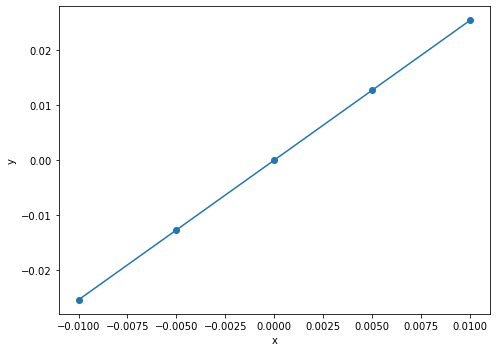

In [32]:
if True: # Necessary otherwise you get an output in the console
    values_lim = 0.01  # calculate the coefficient in the range +/-values_lim
    values_no = 5      # choose how many points you want to calculate
    xvalues = np.linspace(-values_lim, values_lim, values_no)
    yvalues = np.zeros(values_no)
    vectorOld = np.array([[0.], [0.], [0.], [0.], [0.], [0.]])
        
    for i in range (0,values_no):        
        vectorOld[0]=xvalues[i]
        vectorNew = np.dot(matExtracted,vectorOld)
        yvalues[i]=vectorNew[0]

    fig, ax = plt.subplots(1, 1, figsize=(7,5), tight_layout=True, sharex=True)
    ax.plot(xvalues, yvalues, marker = 'o')
    ax.set_xlabel("x")
    ax.set_ylabel("y")

## Plot all the matrix coefficients

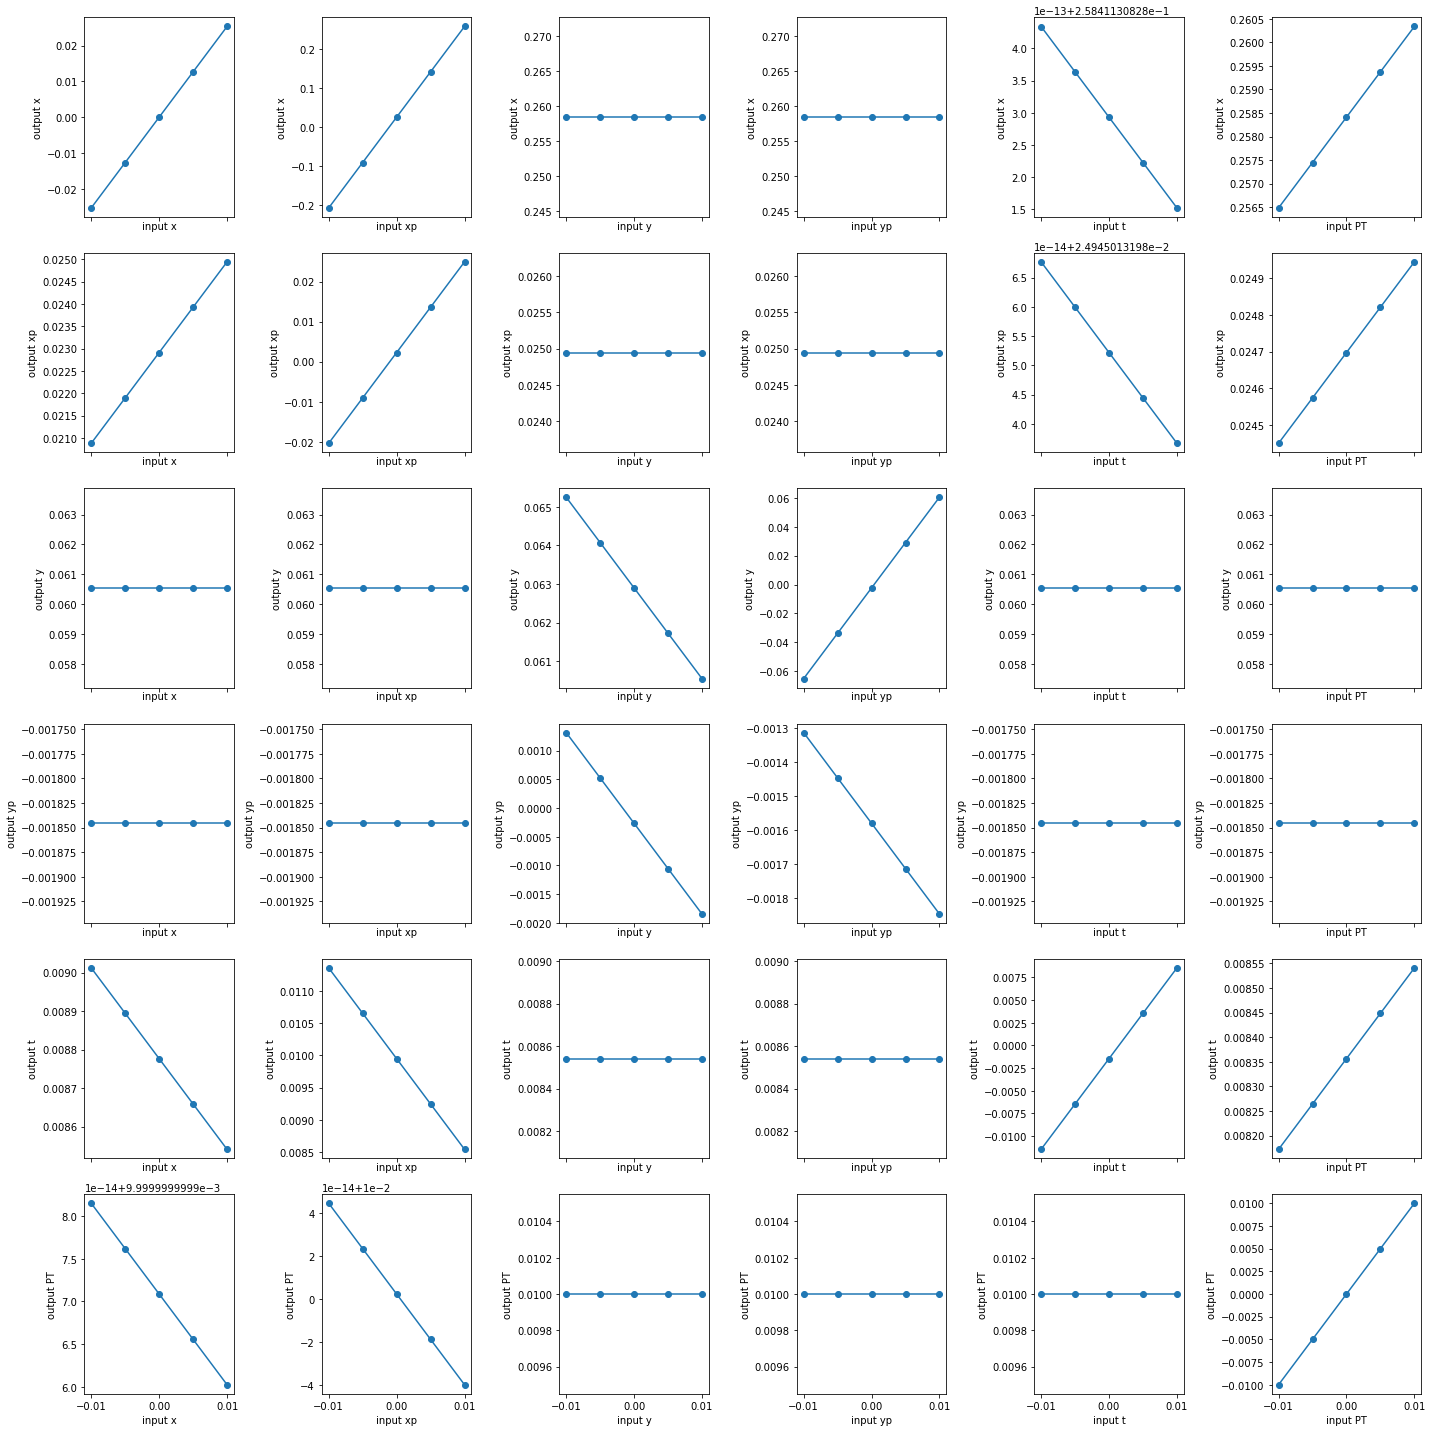

In [33]:
var_names = ("x", "xp", "y", "yp", "t", "PT")
values_no = 5 
values_lim = 0.01
xvalues = np.linspace(-values_lim, values_lim, values_no)
vectorOld = np.array([[0.], [0.], [0.], [0.], [0.], [0.]])

fig, ax = plt.subplots(6,6, figsize=(20,20), tight_layout=True, sharex=True)
for k in range(6):
    for j in range (6):
        yvalues = np.zeros(values_no)
        for i in range (values_no): # In this loop we change the i value from the linspace to varie the input and look at how it impacts the output
            vectorOld[j]=xvalues[i]
            vectorNew = np.dot(matExtracted,vectorOld)
            yvalues[i]=vectorNew[k]

        ax[k,j].plot(xvalues, yvalues, marker = 'o')
        ax[k,j].set_xlabel("input "+var_names[j])
        ax[k,j].set_ylabel("output "+var_names[k])
fig.savefig("plot.pdf", bbox_inches='tight')